# Лабораторная работа 10

## Практика TensorFlow 2.x

Выполнил: 6231, Скиданова Анна

### Задание

В данной лабораторной работе будет практиковаться материал из лекций по TensorFlow на примере решения задачи классификации изображений из датасета Fashion MNIST. Fashion MNIST - набор черно-белых изображений размера 28х28, что поделены на 10 классов. Будет построена с нуля и обучена модель логистической регрессии используя как низкоуровневый API. Опционально решение той же задачи нейронной сетью, построенной и обученной с использованием Keras.

0 Базовые операции.

0.1 Сгенерируйте три непересекающихся гауссовых облака, используя tf.random. Визуализируйте их разными цветами, используя matplotlib.   
0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

(120, 6)

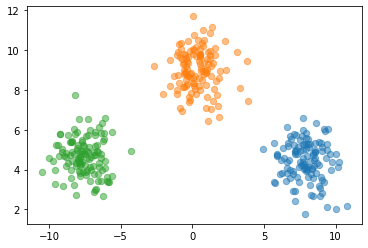

In [2]:
N=3
M=120
x=np.zeros((M,N*2))

#Генерация данных
d=9
a=0.5
for i in range(0,N*2,2):
    x[:,i:i+2]=tf.random.normal((M,2))
    x[:,i]=x[:,i]+d*np.cos(a)
    x[:,i+1]=x[:,i+1]+d*np.sin(a)
    a=a+np.pi/3
    
for i in range(0,N*2,2):
    plt.scatter(x[:,i], x[:,i+1],s=40,alpha=0.5)
x.shape

In [3]:
matr=tf.random.normal((2,2))
result=np.zeros((x.shape[0]*2,x.shape[1]*2))

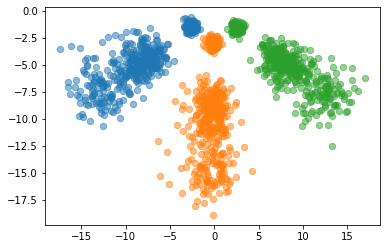

In [4]:
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        res=x[i][j]*matr
        result[i*2:i*2+2,j*2:j*2+2]=res
        #print('i',i,'j',j,result)
for i in range(0,N*2*2,2*2):
    plt.scatter(result[:,i:i+2], result[:,i+2:i+4],s=40,alpha=0.5)  
    

1 Загрузите датасет Fashion MNIST, используя метод из tf.keras.datasets. Визуализируйте несколько изображений, используя библиотеку matplotlib.

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
num_training=12000
num_dev=1000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_dev)
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (12000, 28, 28)
Train labels shape:  (12000,)
Test data shape:  (1000, 28, 28)
Test labels shape:  (1000,)


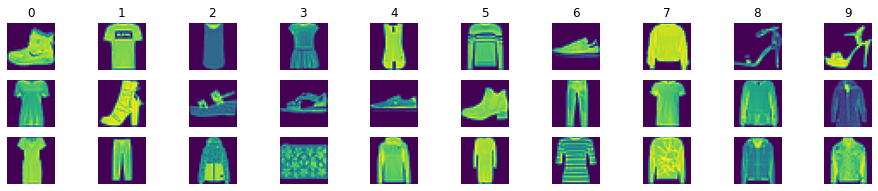

In [7]:
pic_box = plt.figure(figsize=(16,4)) 

for i in range(0,30):
    if(i<10):
        pic_box.add_subplot(4,10,i+1).set_title(i)
    else:
        pic_box.add_subplot(4,10,i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()    

2 Нормализуйте данные либо средним и СКО, либо приведя значения пикселей в интервал [-1, 1].

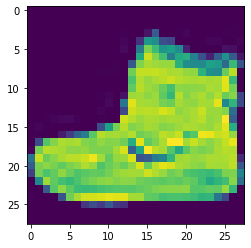

In [8]:
mean, std = np.mean(X_train), np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
plt.imshow(X_train[0])

In [9]:
X_test.shape

(1000, 28, 28)

3 Создайте обучающий и тестовый TensorFlow Dataset из нормализованного набора данных. К обучающему датасету добавьте перемешивание (.shuffle). К обоим датасетам добавьте генерацию батчей размера 128 (.batch(128)).

In [10]:
#X_train, y_train = shuffle(X_train, y_train)

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [12]:
train_dataset = train_dataset.shuffle(buffer_size=len(X_train), reshuffle_each_iteration=True)

In [13]:
train_dataset = train_dataset.batch(128, drop_remainder=True)
test_dataset = test_dataset.batch(128, drop_remainder=True)

4 Напишите класс слоя Flatten, что трансформирует изображения из матричного в векторный вид: [28, 28] -> [28 * 28]. Класс слоя должен наследоваться от tf.Module. Для трансформации тензоров изображений использовать tf.reshape.

In [16]:
class Flatten(tf.Module):

    def __init__(self, name=None):
        super().__init__(name=name)

    def __call__(self, x):
        if len(x.shape) == 2:
            sh = (1, np.prod(x.shape))
        else:
            sh = (x.shape[0], np.prod(x.shape[1:]))
        return tf.reshape(x, shape=sh)

5 Напишите класс линейного слоя Linear, что умножает входной вектор на матрицу весов. Класс слоя должен наследоваться от tf.Module. Матрицу весов хранить в tf.Variable. Параметры конструктора: in_d - размерность входного вектора, out_d - размерность выходного вектора. В качестве начальной инициализации весов использовать гауссово распределение с СКО=0.01.

In [17]:
class Linear(tf.Module):
    def __init__(self, in_d, out_d=1, name=None):
        # in_d - input dimensionality
        # out_d - output dimensionality
        # В случае с tf.Module вызывать конструктор родительского класса обязательно! 
        super().__init__(name=name)
        w = tf.random.normal(shape=[in_d, out_d], stddev=0.01, dtype='float64')
        self.w = tf.Variable(w, name='weight')
        self.b = tf.Variable(tf.zeros(out_d, dtype='float64') * 0.1, name='bias')
        
    def __call__(self, x):
        return tf.matmul(np.array(x), self.w) + self.b

6 Напишите класс модели логистической регрессии LogisticRegression, что компонует в себе слои Linear и Flatten. Класс модели должен наследоваться от tf.Module. В качестве функции активации используйте tf.nn.softmax. Создайте объект модели и попробуйте с помощью неё классифицировать одно изображение (не забудьте о размерности батча! Она будет равна 1).

In [18]:
from tqdm import *

In [19]:
class LogisticRegression(tf.Module):
    def __init__(self, name=None):
        # in_d - input dimensionality
        # out_d - output dimensionality
        # В случае с tf.Module вызывать конструктор родительского класса обязательно! 
        super().__init__(name=name)
        #self.linear = Linear(in_d, out_d)
        self.flatten = Flatten()
             
    def __call__(self, x):
        data=self.flatten(x)
        linear = Linear(data.shape[1], data.shape[0])
        data_l=linear(data)
        pY = tf.nn.softmax(data_l).numpy()
        return pY

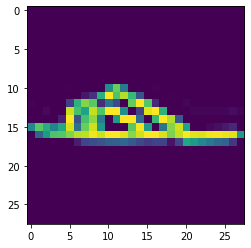

In [20]:
one_p = next(iter(train_dataset))[0][10]
plt.imshow(one_p)

In [21]:
model = LogisticRegression()
y=model(one_p)

7 Напишите функцию оценки точности модели evaluate. Список её аргументов: тестовый tf.Dataset, модель. Данная функция будет отличаться оной из лекций тем, что внутри неё не будет ручной выборки батчей из датасета, поскольку tf.Dataset уже делает это за нас.

In [22]:
def accuracy(y_true, y_pred):
    eq = tf.cast(y_true == y_pred, 'float32')
    return tf.reduce_mean(eq)


def evaluate(model, data_test, batch_size=128):
    l=[]
    y_preds = []
    
    for x, y in data_test:
        l.extend(y)
        preds = model(x)
        preds = tf.argmax(preds, axis=-1)# Находит индекс наибольшего элемента
        y_preds.append(preds)
        
        
    y_preds = tf.concat(y_preds, axis=0)
   
    return accuracy(l, y_preds).numpy()

8 Напишите функцию обучающего шага train_step. Данная функция будет немного отличаться от показанной в лекции тем, что ей на вход также дается функция ошибки. Полный список аргументов: модель, тупл данных (батч картинок, батч меток), оптимизатор, функция ошибки. Функция train_step должна возвращать вычисленное значение функции ошибки.

В данной лабораторной функция ошибки не будет писаться заново, будет использоваться готовая кросс-энтропия из Keras.

In [23]:
N_CLASSES = 10
def train_step(model, data, optim, loss):
    """
    Функция, производящая один обучающий шаг.
    """
    with tf.GradientTape() as tape:
        # "Прогон" данных через модель и вычисление значения функции ошибки
        x, y = data
        x = x.numpy()
        y = y.numpy()
        preds = model(x)
        loss2 = loss( y, preds)
        
    grads = tape.gradient(loss2, model.trainable_variables)
    # Применение градиентов к весам
    optim.apply_gradients(zip(grads, model.trainable_variables))
    return loss2

9 Оцените точность модели.

In [24]:
acc = evaluate(model, train_dataset)
acc

0.007980511

10 Подготовьте гиперпараметры обучения: оптимизатор, функция ошибки (tf.keras.losses.SparseCategoricalCrossentropy), количество эпох.

In [25]:
for_loss = tf.losses.SparseCategoricalCrossentropy()
optim = tf.optimizers.Adam(learning_rate=0.05)
EPOCHS = 5

11 Напишите обучающий цикл. Цикл состоит из внешнего цикла, что отсчитывает эпохи, и вложенного, что итерируется по обучающему датасету. Во вложенном цикле должна вызываться функция train_step. Каждую эпоху модель должна тестироваться функцией evaluate. Должны выводиться номер эпохи, значение ошибки и точности. Сохраняйте значения ошибки и точности в списки. Обучите модель. По ходу обучения подбирайте более оптимальные гиперпараметры обучения (learning_rate, другой оптимизатор).

In [26]:
acc_for_plot=[]
loss_for_plot=[]

for epoch in range(EPOCHS):
    loss_ = []
    acc = []
    for x, y in tqdm(train_dataset):
        
        loss = train_step(model, (x,y),optim, for_loss)
        
        accuracy_value = evaluate(model, test_dataset)
        loss_.append(loss)
        acc.append(accuracy_value)

    mean_loss = np.mean(loss_)
    loss_for_plot.append(mean_loss)
    mean_accuracy = np.mean(acc)
    acc_for_plot.append(mean_accuracy)

    print('Epoch:', epoch, 'Accuracy:', mean_accuracy,'Loss:',mean_loss)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:34<00:00,  2.67it/s]


Epoch: 0 Accuracy: 0.00735647 Loss: 4.8858563053992485


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:34<00:00,  2.70it/s]


Epoch: 1 Accuracy: 0.0070684524 Loss: 4.890198651180472


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:34<00:00,  2.70it/s]


Epoch: 2 Accuracy: 0.0091445865 Loss: 4.903290676814254


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:35<00:00,  2.63it/s]


Epoch: 3 Accuracy: 0.00766849 Loss: 4.8841039185882895


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:34<00:00,  2.67it/s]

Epoch: 4 Accuracy: 0.0076684905 Loss: 4.881278919917281


12 Выведите графики точности и ошибки, используя matplotlib.

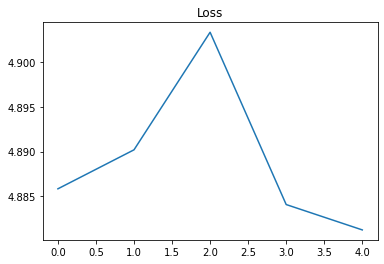

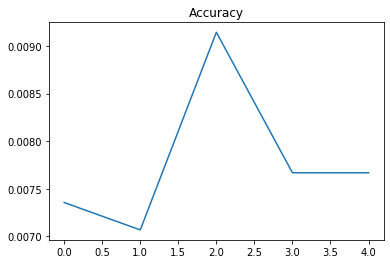

In [27]:
#График лосс и точности модели
plt.plot(loss_for_plot)
plt.title("Loss")
plt.show()

plt.plot(acc_for_plot)
plt.title("Аccuracy")
plt.show()

13 (Опционально) Постройте и обучите произвольную нейронную сеть с использованием Keras для решения той же задачи.

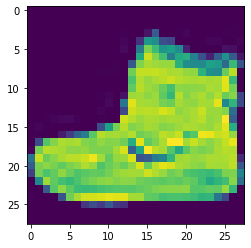

In [37]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

mean, std = np.mean(X_train), np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
plt.imshow(X_train[0])

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=len(X_train), reshuffle_each_iteration=True)

train_dataset = train_dataset.batch(128, drop_remainder=True)
test_dataset = test_dataset.batch(128, drop_remainder=True)

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [39]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [40]:
BATCH_SIZE = 128

In [41]:
import math
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(12000/BATCH_SIZE))

Epoch 1/5
94/94 [==============================] - 8s 77ms/step - loss: 0.7055 - accuracy: 0.7470
Epoch 2/5
94/94 [==============================] - 7s 77ms/step - loss: 0.4380 - accuracy: 0.8420
Epoch 3/5
94/94 [==============================] - 7s 77ms/step - loss: 0.3782 - accuracy: 0.8652
Epoch 4/5
94/94 [==============================] - 7s 77ms/step - loss: 0.3611 - accuracy: 0.8714
Epoch 5/5
94/94 [==============================] - 9s 93ms/step - loss: 0.3322 - accuracy: 0.8802
